In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

In [5]:
# Download and load in a dataset (MNIST handwriting digits datasets) thru DataLoader untils
BATCH_SIZE = 32

#transformations
transform = transforms.Compose([transforms.ToTensor()])

# Download and load in training dataset
trainset = torchvision.datasets.MNIST(root= './GNN', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Download and load in testing dataset
testset = torchvision.datasets.MNIST(root='./GNN', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5457300.32it/s]


Extracting ./GNN/MNIST/raw/train-images-idx3-ubyte.gz to ./GNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159256.43it/s]


Extracting ./GNN/MNIST/raw/train-labels-idx1-ubyte.gz to ./GNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1507418.51it/s]


Extracting ./GNN/MNIST/raw/t10k-images-idx3-ubyte.gz to ./GNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4037839.93it/s]

Extracting ./GNN/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./GNN/MNIST/raw



In [6]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./GNN
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
print(len(testset))

10000


In [8]:
testset[999]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [9]:
# Train a model to classify digits based on their picture.
# Define a model consistanting of one convolutional layer followed by two fully-connected layer
# The model is a subclass of nn.Module which must have forward() function defining exactly what operations get applied to the inputted data
# Model uses predifined modules Conv2d and Linear

class GraphConvolutioanlNetwork(nn.Module):
  def __init__(self):
    super(GraphConvolutioanlNetwork,self).__init__()

    # 28x28x1 --> 26x26x32
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.fc1 = nn.Linear(26*26*32, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    # 32x1x28x28 --> 32x32x26x26
    x = self.conv1(x)
    x= F.relu(x)

    # Flatten --> 32 x (32x26x26)
    x = x.flatten(start_dim=1)
    # x = x.view(32, -1)

    # 32 x (32x26x26) --> 32 x 128
    x = self.fc1(x)
    x = F.relu(x)

    # 32 x 128 --> 32 x 10
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

In [10]:
# With the training model, printing out the training accuracy along the way.
# Start by instantiating a model instance model, a loss function module criterion
# ans optimizer optimizer which will adjust the parameters of the model to
# minimize the loss output by the criterion

epochs = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GraphConvolutioanlNetwork()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Train loop. For each minibatch(accessed by enumerateing thru dataloader trainloader)
# Run data thru a forward pass
# compute the loss with criterion
# Call  optmizer.grad_zero() to zero out the gradients from the previous training
# Followed by loss.backward() to backpropagate the new round of gridnets

for epoch in range(epochs):
  train_losses = 0.0
  train_acc = 0.0

  #Train Step
  for i, (X_train, Y_train) in enumerate(trainloader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    # forward backpropagation loss
    Y_pred = model(X_train)
    loss = criterion(Y_pred, Y_train)
    optimizer.zero_grad()
    loss.backward()

    #update model parameters
    optimizer.step()

    train_losses += loss.detach().item()
    train_acc += (torch.argmax(Y_pred, 1).flatten() == Y_train).type(torch.float).mean().item()

  print('Epoch： %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_losses / i, train_acc / i))


Epoch： 0 | Loss: 0.1774 | Train Accuracy: 0.95
Epoch： 1 | Loss: 0.0556 | Train Accuracy: 0.98


KeyboardInterrupt: 

In [ ]:
# Run the forward pass of the model on the test dataset
test_acc = 0.0
for i,(X_test, Y_test) in enumerate(testloader, 0):
  X_test = X_test.to(device)
  Y_test = Y_test.to(device)
  Y_pred = model(X_test)
  test_acc += (torch.argmax(Y_pred, 1).flatten() == Y_test).type(torch.float).mean().item()

  #preds = torch.argmax(Y_pred, 1).flatten().cpu().numpy()
  #Y_test = Y_test.cpu().numpy()
  #score = metrics.precision_score(preds, Y_test, average='micro')
  #print('Precison:', score)
  #break

print('Test Accuracy: %.2f' %(test_acc/i))

In [ ]:
# Install PyTorch Geometric used to create graph neural networks and TensorboardX used for visualizing the training process
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install TensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [156]:
# import everything we need
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [68]:
# Defining the Model
# Then GNNStack is general framework for a GNN which can handle different kinds of convoluntional layers, and both node and graph classification
# The build_conv_model method determine which type of convoluntional layer to use for the given taks
# Use graph convolutioanl network for node classification, and a graph isomorphism for graph classification
# PyTorch Geometric provides out-of-the-box modules for these layers
# The model consists of 3 layer of convolution, followed by mean pooling in the case of graph classification,
# followed by two fully-connected layers
# The gole is calssification, use a negative log-likelihood loss function

class GNNStack(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
    super(GNNStack, self).__init__()
    self.task = task
    self.convs = nn.ModuleList()
    self.convs.append(self.build_conv_model(input_dim, hidden_dim))
    for a in range(2):
      self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

    # post-message-passing

    self.post_mp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), nn.Linear(hidden_dim, output_dim))


    if not (self.task == 'node' or self.task == 'graph'):
      raise RuntimeError('Unknown task.')

    self.dropout = 0.25
    self.num_layers = 3

  def build_conv_model(self, input_dim, hidden_dim):

    # PyTorch Geometrics nn.Module for different implementation of GNNS
    if self.task == 'node':
        return pyg_nn.GCNConv(input_dim, hidden_dim)
    else:
        return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    if data.num_node_features == 0:
        x = torch.ones(data.num_nodes, 1)

    for i in range(self.num_layers):
      x = self.convs[i](x, edge_index)
      emb = x
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)

      if self.task == 'graph':
        x = pyg_nn.global_mean_pool(x, batch)


      x = self.post_mp(x)

      return emb, F.softmax(x, dim=1)

  def loss(self, Y_pred, Y_train):
    return F.nll_loss(Y_pred, Y_train)

In [43]:
# pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing.
# They define a single layer of graph convolution, which can be decomposed into:
# Message computing, aggregation, update, Pooling
# Derive a new model of subclassing the PyTorch Geometric MessagePassing class rather than using CVNConv GINConv
# Make use of MessagePassing's key building blocks:
# aggr = 'add': The aggregation methods to use('add','mean' and 'max')
# propagate(): The initial call to start propagating messages. Takes in the edge indices and any other data to pass along(e.g. to update node embeddings)
# message(): Construct messages to node i. Take any argument which was intially passed to propagate()
# update(): Update node embeddings. Takes in the output of aggregation as first argument and any arguments which was intially passed to propagate()

class CustomConv(pyg_nn.MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(CustomConv, self).__init__(aggr='add') # add aggregation
    self.lin = nn.Linear(in_channels, out_channels)

  def forward(self, x, edge_index):
    # x has shape [N, in_channels]
    # edge_index has shape [2, E]

    # Add self-loop to adjency matrix
    edge_index, _ = pyg_utils.add_self_loop(edge_index, num_nodes=x.size(0))

    # Transform node feature matrix
    #x = self.lin(x)
    return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

  def message(self, x_j, edge_index, size):
    # Compute messages
    # x_j has shape [E, out_channels]

    row, col = edge_index
    deg = pyg_utils.degree(row, size(0), dtype=x_j.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    norm = deg_inv_sqrt(row) * deg_inv_sqrt(col)

    return norm.view(-1, 1) * x_j

  def update(self, aggr_out):
    # aggr_out has shape [N, out_channels]
    return aggr_out



In [95]:
# Training setup
# Run it forward to compute its predicted label distribution and backpropagate the error
# Node calssification. Define a subset of nodes to be training nodes and rest nodes to be testing nodes
# mask out the testing node during training via batch.train_mask 0.8 for training 0.2 for testing

def train(dataset, task, writer):
  if task == 'graph':
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
  else:
    test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

  # Build model
  model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
  opt = optim.Adam(model.parameters(), lr=0.01)
  # Train
  for epoch in range(200):
    total_loss = 0
    model.train()
    for batch in loader:
      # print(batch, train_mask, '----')
      opt.zero_grad()
      embedding, pred = model(batch)
      label = batch.y
      if task == 'node':
        pred = pred[batch.train_mask]
        label = label[batch.train_mask]

      loss = model.loss(pred, label)
      loss.backward()
      opt.step()
      total_loss += loss.item() * batch.num_graphs
    total_loss /= len(loader.dataset)
    writer.add_scalar('loss', total_loss, epoch)

    if epoch % 10 == 0:
      test_acc = test(test_loader, model)
      print('Epoch {}. loss:{:.4f}. Test Accuracy:{:.4f}'.format(epoch, total_loss, test_acc))
      writer.add_scalar('test accuracy', test_acc, epoch)

  return model

In [93]:
# Test. only one graph. Use masking to determine validation and test set.
# For graph classification tasks, a subset of graph is considered validation or test graph.
def test(loader, model, is_validation=False):
  model.eval()

  correct = 0
  for data in loader:
    with torch.no_grad():
      emb, pred = model(data)
      pred = pred.argmax(dim=1)
      label = data.y

    if model.task == 'node':
      mask = data.val_mask if is_validation else data.test_mask
      # Node classification: only evaluate on nodes in test set
      pred = pred[mask]
      label = label.y[label]

    correct += pred.eq(label).sum().item()

  if model.task == 'graph':
    total = len(loader.dataset)
  else:
    total = 0
    for data in loader.datasets:
      total += torch.sum(data.test_mask).item()
  return correct / total


In [142]:
# Train our model and visualize the process.
# Run this snippet to generate a link to TensorboardX, which will take you to a page where you can visualize the loss and accuracy curves during the process
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &' .format("./log"))
get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4004/api/tunnels | python3 -c 'import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])'



Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [128]:
# Start Train
# See training and testing performance after finishing on the TensorboardX page
# Run following snippet several times, will see several training curve
# start with a graph classificaiton task on the IMDB-BINARY dataset

writer = SummaryWriter('./log' + datetime.now().strftime('%Y%m%d-%H%M%S'))

dataset = TUDataset(root = '/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Epoch 0. loss:-0.1653. Test Accuracy:0.1583
Epoch 10. loss:-0.2296. Test Accuracy:0.1917
Epoch 20. loss:-0.2410. Test Accuracy:0.2167
Epoch 30. loss:-0.2713. Test Accuracy:0.2500
Epoch 40. loss:-0.2755. Test Accuracy:0.2667
Epoch 50. loss:-0.2813. Test Accuracy:0.2917
Epoch 60. loss:-0.2756. Test Accuracy:0.2083
Epoch 70. loss:-0.2981. Test Accuracy:0.2500
Epoch 80. loss:-0.3039. Test Accuracy:0.3083
Epoch 90. loss:-0.2937. Test Accuracy:0.2250
Epoch 100. loss:-0.3153. Test Accuracy:0.2750
Epoch 110. loss:-0.3096. Test Accuracy:0.2833
Epoch 120. loss:-0.3142. Test Accuracy:0.2917
Epoch 130. loss:-0.2952. Test Accuracy:0.2417
Epoch 140. loss:-0.3099. Test Accuracy:0.2667
Epoch 150. loss:-0.3265. Test Accuracy:0.2750
Epoch 160. loss:-0.3191. Test Accuracy:0.3083
Epoch 170. loss:-0.3073. Test Accuracy:0.2833
Epoch 180. loss:-0.2957. Test Accuracy:0.2917
Epoch 190. loss:-0.3225. Test Accuracy:0.3000


In [134]:
writer = SummaryWriter('./log' + datetime.now().strftime('%Y%m%d-%H%M%S'))

dataset = TUDataset(root = '/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Processing...
Done!


Epoch 0. loss:-0.5116. Test Accuracy:0.4900
Epoch 10. loss:-0.6573. Test Accuracy:0.6050
Epoch 20. loss:-0.6550. Test Accuracy:0.5850
Epoch 30. loss:-0.6636. Test Accuracy:0.6050
Epoch 40. loss:-0.6372. Test Accuracy:0.6150
Epoch 50. loss:-0.6751. Test Accuracy:0.6150
Epoch 60. loss:-0.6632. Test Accuracy:0.6600
Epoch 70. loss:-0.6739. Test Accuracy:0.6250
Epoch 80. loss:-0.6617. Test Accuracy:0.6350
Epoch 90. loss:-0.6371. Test Accuracy:0.6450
Epoch 100. loss:-0.6669. Test Accuracy:0.6150
Epoch 110. loss:-0.5915. Test Accuracy:0.5900
Epoch 120. loss:-0.6507. Test Accuracy:0.5900
Epoch 130. loss:-0.6598. Test Accuracy:0.6250
Epoch 140. loss:-0.6648. Test Accuracy:0.6150
Epoch 150. loss:-0.6265. Test Accuracy:0.5600
Epoch 160. loss:-0.6735. Test Accuracy:0.6650
Epoch 170. loss:-0.6460. Test Accuracy:0.6650
Epoch 180. loss:-0.6557. Test Accuracy:0.5850
Epoch 190. loss:-0.6644. Test Accuracy:0.6300


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 19773.

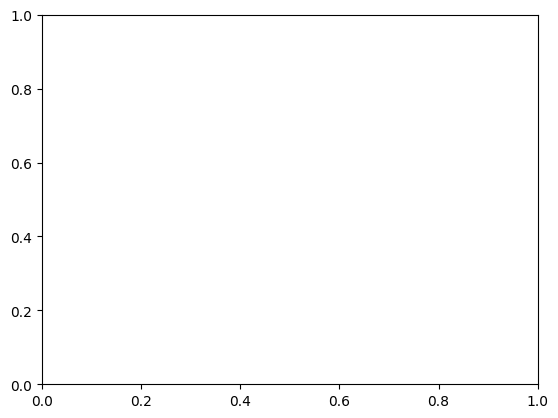

In [149]:
# Visualizing node embeeding
# low-dimensional --> TSNE high dimensional data
# Nodes are colored according their labels
# Nodes with similar labels are tend to be near each other in the embedding space, representating the model has learned from the data

color_list = ['red','orange', 'green', 'blue', 'purple', 'brown']
loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
  emb, pred = model(batch)
  embs.append(emb)
  colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

In [166]:
# Learning unsupervised embeddings with graph autoencoders
# Enconde the nodes in our network in a low-dimensional space in a way that the embedding can be decoded into a reconstruction of the original network.
# Use graph convolutioanl layers in encoder
# Use tensornoardX to visualize the training process
class Encoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Encoder, self).__init__()
    self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
    self.conv1 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

  def forward(self, x, edge_index):
    x = F.relu(self.conv1(x, edge_index))
    return self.conv2(x, edge_index)

def train(epoch):
  model.train()
  optimizer.zero_grad()
  z = model.encode(x, train_pos_edge_index)
  loss = model.recon_loss(z, train_pos_edge_index)
  loss.backward()
  optimizer.step()

  writer.add_scalar('loss', loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
  model.eval()
  with torch.no_grad():
    z = model.encode(x, train_pos_edge_index)
  return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter('./log/' + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid('/tmp/ENZEMY', 'ENZEMY', T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA Availability:', torch.cuda.is_available())

#encoder:written decoder:default(inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = model.split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
  train(epoch)
  auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
  writer.add_scalar("AUC", auc, epoch)
  writer.add_scalar("AP", ap, epoch)
  if epoch % 10 == 0:
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))



AttributeError: 'NormalizeFeatures' object has no attribute 'lower'

In [167]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy))
plt.scatter(xs, ys, color=colors)
plt.show

NameError: name 'x' is not defined